In [1]:
# Import libraries
import os
import sys
import torch
import gc
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
# Set path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [3]:
# Import modules
from src.data.dataset import ThermalDataset
from src.utils.visualization import plot_class_distribution
from src.data.dataset import save_large_dataset

In [5]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Load preprocessed dataset
print("\nLoading preprocessed dataset...")
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
preprocessed_dataset_path = os.path.join(project_root, 'data', 'processed', 'preprocessed_dataset.pt')
preprocessed_dataset = torch.load(preprocessed_dataset_path, weights_only=False)


Loading preprocessed dataset...


In [7]:
# Print shapes before any operations
print("\nOriginal tensor shapes:")
print(f"Corrected: {preprocessed_dataset['tensors']['corrected'].shape}")


Original tensor shapes:
Corrected: torch.Size([480, 640, 7024])


In [8]:
# We need to permute the tensors before splitting
print("\nReorganizing tensors...")
preprocessed_dataset['tensors']['corrected'] = preprocessed_dataset['tensors']['corrected'].permute(2, 0, 1)
preprocessed_dataset['tensors']['edge'] = preprocessed_dataset['tensors']['edge'].permute(2, 0, 1)
for level in preprocessed_dataset['tensors']['threshold'].keys():
    preprocessed_dataset['tensors']['threshold'][level] = preprocessed_dataset['tensors']['threshold'][level].permute(2, 0, 1)

print("\nTensor shapes after permute:")
print(f"Corrected: {preprocessed_dataset['tensors']['corrected'].shape}")


Reorganizing tensors...

Tensor shapes after permute:
Corrected: torch.Size([7024, 480, 640])


In [9]:
# Now split using the correct dimension
n_samples = len(preprocessed_dataset['labels']['numeric_labels'])
print(f"\nTotal number of samples: {n_samples}")

# Split data
print("\nSplitting data into train and validation sets...")
labels = preprocessed_dataset['labels']['numeric_labels']
train_idx, val_idx = train_test_split(
    range(n_samples), 
    test_size=0.2, 
    stratify=labels,
    random_state=42
)

print(f"Training indices: {len(train_idx)}, max index: {max(train_idx)}")
print(f"Validation indices: {len(val_idx)}, max index: {max(val_idx)}")


Total number of samples: 7024

Splitting data into train and validation sets...
Training indices: 5619, max index: 7022
Validation indices: 1405, max index: 7023


In [10]:
# Create datasets
train_dataset = ThermalDataset(preprocessed_dataset, indices=train_idx)
val_dataset = ThermalDataset(preprocessed_dataset, indices=val_idx)

In [11]:
# Print final dataset information
print("\nFinal dataset splits:")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")


Final dataset splits:
Training samples: 5619
Validation samples: 1405


In [12]:
# Create processed directory
processed_dir = os.path.join(project_root, 'data', 'processed')
os.makedirs(processed_dir, exist_ok=True)

# Save datasets
print("\nSaving datasets...")
save_large_dataset(train_dataset, processed_dir, "train")
save_large_dataset(val_dataset, processed_dir, "val")


Saving datasets...

Saving train...
Saving corrected tensor with 5619 samples...
Saving edge tensor with 5619 samples...
Saving threshold tensors...
Saving threshold tensor 'low' with 5619 samples...
Saving threshold tensor 'medium' with 5619 samples...
Saving threshold tensor 'high' with 5619 samples...
Saving threshold tensor 'very_high' with 5619 samples...
Saving labels and metadata with 5619 samples...
train saved successfully!

Saving val...
Saving corrected tensor with 1405 samples...
Saving edge tensor with 1405 samples...
Saving threshold tensors...
Saving threshold tensor 'low' with 1405 samples...
Saving threshold tensor 'medium' with 1405 samples...
Saving threshold tensor 'high' with 1405 samples...
Saving threshold tensor 'very_high' with 1405 samples...
Saving labels and metadata with 1405 samples...
val saved successfully!


True

In [13]:
gc.collect()
torch.cuda.empty_cache()

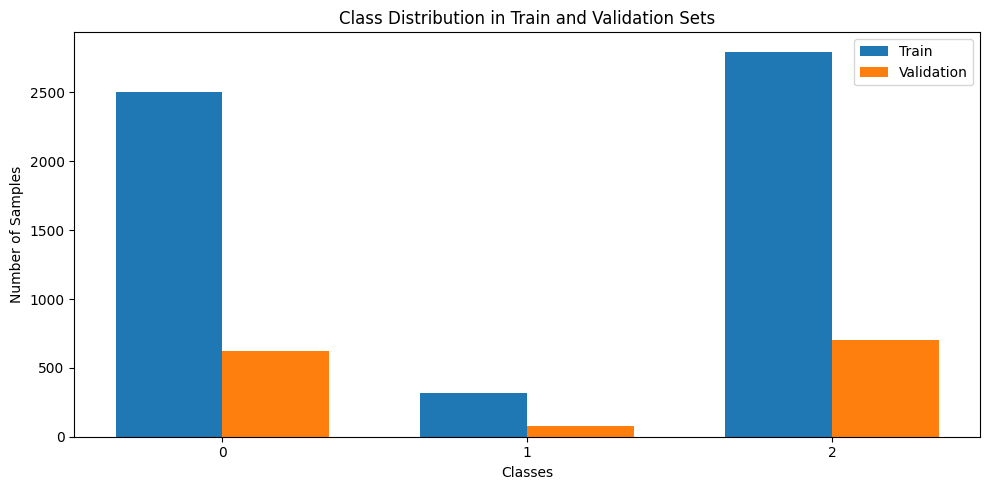

In [14]:
plot_class_distribution(train_dataset, val_dataset)